In [86]:
import pymysql
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from item_embedding import item_encode
from preprocess_user import make_user_fans_pipeline
from etl import load_user_info_features
from etl import load_fans_info_features

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_auc_score,accuracy_score

from tensorflow.keras.layers import Input, Embedding, Dot, Add,Flatten,Dense,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD,Adam
import tensorflow as tf

In [99]:
def preprocess_goods():
    '''
        Get goods data
        Encode goods to vectors
        
        Parameters:
        
        Returns:
            encoded_items: (N_items, item_embedding_dimension)
            goods: goods dataframe
    '''
    conn = pymysql.connect(host = '127.0.0.1', 
                       user = 'root', 
                       password = 'root123', 
                       db = 'delidou')

    goods = pd.read_sql_query('''
        select g.* from base_goods g
        inner join(
            select distinct u.id as uid from base_user_info u
            inner join(
                select id from base_user_fans
            ) f on u.id = f.id
        ) uf on g.id = uf.uid
    ''', conn)
    
    encoded_items,goods = item_encode(goods)
    goods = goods.reset_index(drop = True)
    
    n_users = goods['id'].nunique()
    n_items = goods.link_id.nunique()
    n_pref = goods.shape[0]

    # print('Number of users: {}'.format(n_users))
    # print('Number of items: {}'.format(n_items))
    # print('Number of records: {}'.format(n_pref))
    
    return encoded_items, goods


def filter_goods_and_users(goods, user_n_item = 10, item_n_user = 10):
    '''
        Select top users and items
    '''
    
    item_count = goods.groupby('link_id')['id']\
        .agg(lambda x:len(set(x))).reset_index()\
        .sort_values(by = 'id',ascending = False)
    
    top_link_ids = item_count[item_count.id > item_n_user].link_id.values
    
    user_count = goods.groupby('id')['link_id']\
        .agg(lambda x:len(set(x))).reset_index()\
        .sort_values(by = 'link_id',ascending = False)
    
    top_user_ids = user_count[user_count.link_id > user_n_item].id.values
    
    goods = goods[(goods.id.isin(top_user_ids)) & (goods.link_id.isin(top_link_ids))]
    # goods = goods[(goods.id.isin(top_user_ids)) & (goods.link_id.isin(top_link_ids)) & (goods.id.isin(user_fans.id.values))]
    
    return goods,top_link_ids, top_user_ids



def load_user_features(n_regions = 30):
    
    '''Load user and fans data, process using predefined pipeline'''
    
    user = load_user_info_features()
    fans = load_fans_info_features()
    user_fans = user.merge(fans, on = 'id', how = 'inner')
    pipe = make_user_fans_pipeline(n_regions)
    user_features = pipe.fit_transform(user_fans)
    return user_features, user_fans



def userinfo_to_id(user_features, user_fans, user2id):
    result = []
    for user, f  in zip(user_fans.id.values, user_features):
        if user in user2id.keys():
            result.append([user2id[user],*f])

    user_features = pd.DataFrame(result)
    user_features.columns = ['user_id' if col == 0 else 'F_' + str(col) for col in user_features]
    user_features = user_features.iloc[:,1:]
    return user_features



def make_rating_table(goods):
    '''
        Make a 3 column rating table
    '''
    ratings = goods[['id','link_id']].copy()
    ratings['rating'] = 1
    ratings = ratings.rename(columns = {'id':'user_id','link_id':'item_id'})
    user2id = {user:i for i, user in enumerate(ratings.user_id.unique())}
    item2id = {item:i for i, item in enumerate(ratings.item_id.unique())}
    ratings['user_id'] = ratings['user_id'].replace(user2id)
    ratings['item_id'] = ratings['item_id'].replace(item2id)
    return ratings, user2id, item2id



def negative_sampling(ratings, n_negative = 50):
    '''
        Negative sampling
    '''
    all_items = set(ratings.item_id.unique())
    negative_samples = []
    for user_id in ratings.user_id.unique():
        user_items = set(ratings[ratings.user_id == user_id]['item_id'].tolist())
        space = list(all_items.difference(set(user_items)))
        neg_items = np.random.choice(space, size = n_negative)
        for neg_item in neg_items:
            negative_samples.append([user_id, neg_item,0])
    neg_ratings = pd.DataFrame(negative_samples,columns = ['user_id','item_id','rating'])
    dataset = pd.concat([ratings, neg_ratings])
    return dataset



def recommend_train_test_split(dataset, encoded_items, user_features, 
                               test_size = 0.1, shuffle = True):
    
    X_train, X_test, y_train,y_test =  train_test_split(dataset[['user_id','item_id']], 
                                                    dataset['rating'], 
                                                    test_size = 0.1, 
                                                    shuffle = True)

    item_encode_train = encoded_items[X_train.item_id.values]
    item_encode_test = encoded_items[X_test.item_id.values]
    
    user_feature_train = user_features.iloc[X_train.user_id.values,:]
    user_feature_test = user_features.iloc[X_test.user_id.values,:]
    
    
    print_info = '''
    ======================================
    Dataset Summary:
    ======================================
    X_train: {}
    X_test: {}
    item_encode_train: {}
    item_encode_test: {}
    user_feature_train: {}
    user_features_test: {}
    ======================================
    '''.format(X_train.shape, X_test.shape, 
               item_encode_train.shape, item_encode_test.shape, 
               user_feature_train.shape, user_feature_test.shape)
    
    print(print_info)
    
    return X_train, item_encode_train, user_feature_train,\
            X_test, item_encode_test, user_feature_test,y_train, y_test


def get_recommend_model(n_users, n_items, item_feature_dim, user_feature_dim, embed_hidden_dim = 10, reg = 0.):
    
    user_input = Input(1,)
    item_input = Input(1,)
    encoded_items_tensor = Input(item_feature_dim,)
    input_user_feature = Input(user_feature_dim,)

    user_embedding = Embedding(n_users,embed_hidden_dim, embeddings_regularizer=l2(reg))(user_input)
    item_embedding = Embedding(n_items,embed_hidden_dim, embeddings_regularizer=l2(reg))(item_input)

    user_bias = Embedding(n_users,1, embeddings_regularizer=l2(reg))(user_input)
    item_bias = Embedding(n_items,1, embeddings_regularizer=l2(reg))(item_input)

    rating_pred = Dot(axes = 2)([user_embedding, item_embedding])
    rating_pred = Add()([rating_pred, user_bias, item_bias])
    rating_pred = Flatten()(rating_pred)
    rating_pred = Concatenate()([rating_pred,encoded_items_tensor,input_user_feature])
    rating_pred = Dense(16, activation = 'relu')(rating_pred)
    rating_pred = Dense(1, activation = 'sigmoid')(rating_pred)

    model = Model([user_input, item_input,encoded_items_tensor,input_user_feature],rating_pred)
        
    model.compile(optimizer = Adam(lr = 0.001),loss = tf.keras.losses.BinaryCrossentropy(),metrics = ['accuracy'])
    return model
    
    
def evaluate_model(model, X_test, item_encode_test, user_feature_test,y_test):
    
    # predict
    preds = (model.predict(x = [X_test.user_id.values,
                                X_test.item_id.values,
                                item_encode_test, 
                                user_feature_test]) > 0.5).flatten()
    
    confuse = confusion_matrix(y_test, preds)
    fig, ax = plt.subplots(figsize = (6,4))
    sns.heatmap(confuse / confuse.sum(), annot = True)
    plt.title('Confusion Matrix')
    plt.show()
    
    auc = roc_auc_score(y_test, preds)
    acc = accuracy_score(y_test, preds)
    print('Accuracy Score: {}'.format(acc))
    print('Auc score: {}'.format(auc))

In [105]:
# items related pipelines
encoded_items, goods = preprocess_goods()
goods, top_link_ids, top_user_ids = filter_goods_and_users(goods)
ratings, user2id, item2id = make_rating_table(goods)
id2user = {v:k for k,v in user2id.items()}
id2item = {v:k for k,v in item2id.items()}

# user related pipelines
user_features, user_fans_df = load_user_features()
user_features = userinfo_to_id(user_features,user_fans_df,user2id)

# negative sampling ratings
dataset = negative_sampling(ratings)

# split and merge item and user data
X_train, item_encode_train, user_feature_train, \
    X_test, item_encode_test, user_feature_test,\
    y_train, y_test = recommend_train_test_split(dataset, 
                                                 encoded_items, 
                                                 user_features, 
                                                 test_size = 0.1,
                                                 shuffle = True)

# model structure based on data
model_params = dict(
    n_users = ratings.user_id.nunique(),
    n_items = ratings.item_id.nunique(),
    item_feature_dim = item_encode_train.shape[1],
    user_feature_dim = user_feature_train.shape[1],
    embed_hidden_dim = 10,
    reg = 0.
    )

# get the model
model = get_recommend_model(**model_params)


    Dataset Summary:
    X_train: (151836, 2)
    X_test: (16871, 2)
    item_encode_train: (151836, 128)
    item_encode_test: (16871, 128)
    user_feature_train: (151836, 127)
    user_features_test: (16871, 127)
    


In [106]:
EPOCHS = 20

history = model.fit(x = [X_train.user_id.values,X_train.item_id.values,item_encode_train,user_feature_train.values],y = y_train.values,
                   epochs = EPOCHS,
                   batch_size = 1024,
                   validation_data = (
                   [X_test.user_id.values,X_test.item_id.values,item_encode_test,user_feature_test], y_test.values)
                   )

Train on 151836 samples, validate on 16871 samples
Epoch 1/20
151836/151836 [==============================] - 2s 10us/sample - loss: 0.4543 - accuracy: 0.8327 - val_loss: 0.4219 - val_accuracy: 0.8487
Epoch 2/20
151836/151836 [==============================] - 1s 6us/sample - loss: 0.4173 - accuracy: 0.8481 - val_loss: 0.4090 - val_accuracy: 0.8488
Epoch 3/20
151836/151836 [==============================] - 1s 6us/sample - loss: 0.3954 - accuracy: 0.8486 - val_loss: 0.3829 - val_accuracy: 0.8507
Epoch 4/20
151836/151836 [==============================] - 1s 5us/sample - loss: 0.3466 - accuracy: 0.8624 - val_loss: 0.3435 - val_accuracy: 0.8687
Epoch 5/20
151836/151836 [==============================] - 1s 5us/sample - loss: 0.2910 - accuracy: 0.8878 - val_loss: 0.3189 - val_accuracy: 0.8809
Epoch 6/20
151836/151836 [==============================] - 1s 5us/sample - loss: 0.2498 - accuracy: 0.9042 - val_loss: 0.3046 - val_accuracy: 0.8866
Epoch 7/20
151836/151836 [======================

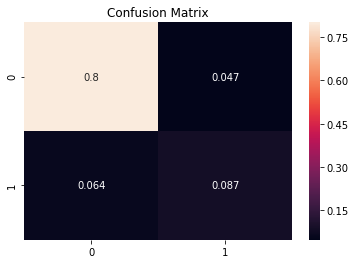

Accuracy Score: 0.8886254519589829
Auc score: 0.7594537496523437


In [107]:
evaluate_model(model, X_test, item_encode_test, user_feature_test,y_test)

In [129]:
def generate_recommends():
    all_items = set(ratings.item_id.unique())
    user = np.random.choice(X_test.user_id.values)
    user = np.repeat([user],len(all_items))  

    recos = np.argsort(model.predict([user, np.array(list(all_items)),encoded_items[list(all_items),],user_features.iloc[user].values]).flatten())[::-1][:30]
    goods[goods['id'] == id2user[user[0]]]

    print('Recommendation List:\n')
    for i, reco in enumerate(recos):
        print('No {}, Item: {}'.format(i+1,goods[goods.link_id == id2item[reco]]['name'].iloc[0]))

    print('\n\nKnown positive:\n')
    for i, good in enumerate(goods[goods['id'] == id2user[user[0]]]['name'].unique().tolist()):
        print('No {}, Item: {}'.format(i, good))

In [130]:
generate_recommends()

Recommendation List:

No 1, Item: usmile电动牙刷男女成人充电式软毛牙刷声波自动电动牙刷Y1
No 2, Item: 完美日记金色散粉蜜粉定妆粉持久控油防水空气蜜粉/散粉女三丽鸥
No 3, Item: 小奥汀睫毛膏 浓密防水纤长卷翘持久不晕染不脱妆加长女彩色奥丁
No 4, Item: ZEESEA滋色李汶翰代言埃及蜜粉饼散粉定妆粉控油持久防水防汗遮瑕
No 5, Item: 韩束金刚侠黄金面膜补水保湿提拉紧致熬夜修护金箔女男士专用正品
No 6, Item: 欧丽源电动眼霜淡化细纹黑眼圈眼袋提拉紧致补水保湿女学生
No 7, Item: 小奥汀雾感唇釉 丝绒雾面哑光唇彩唇蜜小众品牌女保湿滋润口红
No 8, Item: 欧诗漫小白灯美白精华液面部精华女烟酰胺淡斑精华提亮肤色肌底液
No 9, Item: colorkey珂拉琪丝绒雾面哑光空气唇釉唇彩女学生口红王子异星选
No 10, Item: 明星同款 冰希黎流沙金女士香水持久淡香学生少女清新正品
No 11, Item: 完美日记天鹅绒丝绒唇釉女V08雾面哑光口红唇彩持久平价学生V01
No 12, Item: 完美日记白胖子氨基酸卸妆湿巾女眼唇脸部温和清洁单片装一次性
No 13, Item: 完美日记动物眼影盘锦鲤小狗小猫猫咪老虎斑虎小猪熊猫小鹿盘女
No 14, Item: 半亩花田苦参除螨皂洗脸硫磺皂非海盐香皂面部男女深层清洁手工皂
No 15, Item: 小奥汀眼线液笔 彩色防水不晕染持久棕色胶笔极细新手初学者奥丁
No 16, Item: ROAMAN/罗曼电动牙刷成人款情侣软毛洁面自动牙刷T10S小菓刷
No 17, Item: 花西子空气蜜粉/散粉定妆粉饼女持久控油防水防汗遮瑕不脱妆自然
No 18, Item: HOF色彩之源粉底液遮瑕保湿持久干皮养肤型油皮亲妈学生遮盖斑点
No 19, Item: 乐在其中小冰棒冰淇淋丝绒雾面哑光空气唇釉女唇彩学生款平价口红
No 20, Item: 薇娅推荐御泥坊氨基酸泥浆面膜深层清洁黑头毛孔控油涂抹式泥膜
No 21, Item: 小奥汀双头极细眉笔 棕色持久不脱色不晕染初学者正品初学者女
No 22, Item: 一叶子小V脸提拉面膜 面部修护提拉紧致淡化细纹补水保湿抗糖
No 23, Item: 半亩花田乳

In [34]:
# conn = pymysql.connect(host = '127.0.0.1', 
#                        user = 'root', 
#                        password = 'root123', 
#                        db = 'delidou')

# goods = pd.read_sql_query('select * from base_goods', conn)

# encoded_items,goods = item_encode(goods)
# goods = goods.reset_index(drop = True)

# link_to_location = {link_id:location for location, link_id in goods['link_id'].reset_index().values}


# n_users = goods['id'].nunique()
# n_items = goods.link_id.nunique()
# n_pref = goods.shape[0]

# print('Number of users: {}'.format(n_users))
# print('Number of items: {}'.format(n_items))
# print('Number of records: {}'.format(n_pref))

# item_count = goods.groupby('link_id')['id'].agg(lambda x:len(set(x))).reset_index().sort_values(by = 'id',ascending = False)
# top_link_ids = item_count[item_count.id > 10].link_id.values
# user_count = goods.groupby('id')['link_id'].agg(lambda x:len(set(x))).reset_index().sort_values(by = 'link_id',ascending = False)
# top_user_ids = user_count[user_count.link_id > 10].id.values

# user = load_user_info_features()
# fans = load_fans_info_features()
# user_fans = user.merge(fans, on = 'id', how = 'inner')
# pipe = make_user_fans_pipeline(30)
# user_features = pipe.fit_transform(user_fans)

# goods = goods[(goods.id.isin(top_user_ids)) & (goods.link_id.isin(top_link_ids))]
# goods = goods[(goods.id.isin(top_user_ids)) & (goods.link_id.isin(top_link_ids)) & (goods.id.isin(user_fans.id.values))]

# ratings = goods[['id','link_id']].copy()
# ratings['rating'] = 1

# ratings = ratings.rename(columns = {'id':'user_id','link_id':'item_id'})
# user2id = {user:i for i, user in enumerate(ratings.user_id.unique())}
# item2id = {item:i for i, item in enumerate(ratings.item_id.unique())}
# ratings['user_id'] = ratings['user_id'].replace(user2id)
# ratings['item_id'] = ratings['item_id'].replace(item2id)

# result = []
# for user, f  in zip(user_fans.id.values, user_features):
#     if user in user2id.keys():
#         result.append([user2id[user],*f])
        
# user_features = pd.DataFrame(result)
# user_features.columns = ['user_id' if col == 0 else 'F_' + str(col) for col in user_features]
# user_features = user_features.iloc[:,1:]

# all_items = set(ratings.item_id.unique())
# n_negative = 50
# negative_samples = []
# for user_id in ratings.user_id.unique():
#     user_items = set(ratings[ratings.user_id == user_id]['item_id'].tolist())
#     space = list(all_items.difference(set(user_items)))
#     neg_items = np.random.choice(space, size = n_negative)
#     for neg_item in neg_items:
#         negative_samples.append([user_id, neg_item,0])
# neg_ratings = pd.DataFrame(negative_samples,columns = ['user_id','item_id','rating'])
# dataset = pd.concat([ratings, neg_ratings])

# itemid_to_location = {id_:link_to_location[link]for link,id_ in item2id.items()}
# X_train, X_test, y_train,y_test =  train_test_split(dataset[['user_id','item_id']], 
#                                                     dataset['rating'], 
#                                                     test_size = 0.1, 
#                                                     shuffle = True)

# item_encode_train = encoded_items[X_train.item_id.values]
# item_encode_test = encoded_items[X_test.item_id.values]
# user_feature_train = user_features.iloc[X_train.user_id.values,:]
# user_feature_test = user_features.iloc[X_test.user_id.values,:]



In [62]:
# reg = 0.

# user_input = Input(1,)
# item_input = Input(1,)
# encoded_items_tensor = Input(128,)
# input_user_feature = Input(127,)

# user_embedding = Embedding(N,K, embeddings_regularizer=l2(reg))(user_input)
# item_embedding = Embedding(M,K, embeddings_regularizer=l2(reg))(item_input)

# user_bias = Embedding(N,1, embeddings_regularizer=l2(reg))(user_input)
# item_bias = Embedding(M,1, embeddings_regularizer=l2(reg))(item_input)

# rating_pred = Dot(axes = 2)([user_embedding, item_embedding])
# rating_pred = Add()([rating_pred, user_bias, item_bias])
# rating_pred = Flatten()(rating_pred)
# rating_pred = Concatenate()([rating_pred,encoded_items_tensor,input_user_feature])
# rating_pred = Dense(16, activation = 'relu')(rating_pred)
# rating_pred = Dense(1, activation = 'sigmoid')(rating_pred)

# model = Model([user_input, item_input,encoded_items_tensor,input_user_feature],rating_pred)

# plot_model(model,show_shapes = True)

# model.compile(optimizer = Adam(lr = 0.001),loss = tf.keras.losses.BinaryCrossentropy(),metrics = ['accuracy'])

In [103]:
# preds = (model.predict(x = [X_test.user_id.values,X_test.item_id.values,item_encode_test, user_feature_test]) > 0.5).flatten()
# confusion_matrix(y_test, preds)